In [93]:
import sys
import os
import datetime
sys.path.append('/home/sejones/workspace/src')

import pricing.black_scholes as bs
import simulation.sim as sim 
%matplotlib inline

In [94]:
import matplotlib.pyplot as plt

In [95]:
import numpy as np
import pandas as pd

In [96]:
import seaborn as sns

In [327]:
plt.style.use("seaborn-whitegrid")

,tau,spot,E[v],sd[v],vega,pnl sd,pnl sd approx
Results,"[5, 4, 5, 2, 4, 4, 2, 6, 2, 6, 5, 5, 1, 4, 3, ...",3.14159,0.200295,0.102053,0.507847,0.0541784,0.0553752


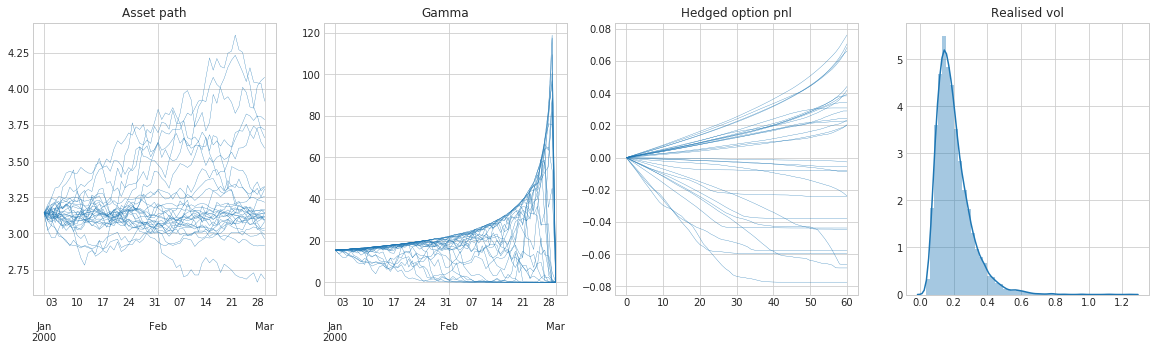

In [457]:
def run(num_paths, initial_spot, start_date, end_date, vol_expec, vol_stdev, freq='D'):

    DAYS_PER_YEAR = 365
    
    m = vol_expec # just shorthand: variable alias
    s = vol_stdev
    mu =np.log(m/np.sqrt(1+(s/m)**2))
    sigma = np.sqrt(np.log(1+(s/m)**2))
    
    vol = np.exp(np.random.normal(mu,sigma,size=num_paths)).reshape(1,-1)
    
    sim_dates = pd.date_range(start_date, end_date, freq = freq)
    time_axis = ((sim_dates - sim_dates[0]).days / DAYS_PER_YEAR).values.reshape(-1,1)
    rnd = data = np.random.normal(size = (len(sim_dates)-1,num_paths))
    paths = np.cumsum(np.concatenate((np.zeros((1,num_paths)), rnd * np.sqrt((time_axis[1:]-time_axis[:-1]))), axis=0), axis=0)
    paths = initial_spot * np.exp((paths * vol) + (time_axis*(drift-vol**2)))
    paths = pd.DataFrame(paths, index=sim_dates)

    implied_vol = vol.mean()

    time_to_expiry = ((sim_dates[-1] - sim_dates).days / DAYS_PER_YEAR).values.reshape(-1,1)
    gamma = bs.cash_gamma(initial_spot, paths.values, implied_vol, time_to_expiry)
    gamma = pd.DataFrame(gamma, index=sim_dates)

    dt = time_to_expiry[:-1]-time_to_expiry[1:]
    pnl = 0.5 * np.cumsum(np.concatenate((np.zeros((1,num_paths)), (implied_vol*implied_vol-vol*vol) * gamma.values[:-1] * dt)), axis=0)
    pnl = pd.DataFrame(pnl)
    return paths, gamma, pnl, vol

initial_spot = np.pi
num_paths = 10000
vol_expec = 0.2
vol_stdev = 0.1

start_date = datetime.datetime(2000,1,1)
end_date = datetime.datetime(2000,3,1)

paths, gamma, pnl, vol = run(num_paths, initial_spot, start_date, end_date, vol_expec, vol_stdev)

n_plots=30
fig, ax = plt.subplots(1,4, figsize=(20,5))
paths.iloc[:,:n_plots].plot(ax=ax[0], legend=False, color="C0", linewidth=0.3)
gamma.iloc[:,:n_plots].plot(ax=ax[1], legend=False, color="C0", linewidth=0.3)
pnl.iloc[:,:n_plots].plot(ax=ax[2], legend=False, color="C0", linewidth=0.3)
sns.distplot(vol, ax=ax[3])

ax[0].set_title("Asset path")
ax[1].set_title("Gamma")
ax[2].set_title("Hedged option pnl")
ax[3].set_title("Realised vol")

tau = (end_date  -start_date).days / DAYS_PER_YEAR
vega = bs.vega(initial_spot, initial_spot, implied_vol, tau)

pd.Series({"tau":months,
    "spot" : initial_spot,
    "E[v]" : np.mean(vol),
    "sd[v]" : np.std(vol),
    "vega" : vega,
     "pnl sd" : pnl.iloc[-1,:].std(),
     "pnl sd approx" : np.std(vol)*vega*np.sqrt(np.pi-2),
    }).to_frame("Results").T

In [458]:
# we test our approximation for various different parameters:
num_tests = 100

# in particular, we try various different levels of expected realised vol,
# and different levels of uncertainty around that expectation
# our expected vols for the tests are drawn from a lognormal distribution:

m = 0.2
s = 0.1
mu =np.log(m/np.sqrt(1+(s/m)**2))
sigma = np.sqrt(np.log(1+(s/m)**2))

expected_vol = np.exp(np.random.normal(mu,sigma,size=num_tests))

# then the realised vols in each test are also drawn from a lognormal, with the expectation
# as given, abd the stdev taken from a uniform distribution over the interval of up to half the expectation
stdev_vol = expected_vol * np.random.uniform(size=num_tests)*0.5

# spot levels are exponentially distributed
initial_spot = -10*np.log(np.random.uniform(size=num_tests))

# time to expiry is a nuber of whole calendar months sampled from a discrete uniform
months = np.random.randint(1,7, size=num_tests)

In [459]:
results = []
for i in range(num_tests):
    
    if (0==i%10):
        print(i)
    num_paths = 1000
    start_date = datetime.datetime(2000,1,1)
    end_date = datetime.datetime(2000,1+months[i],1)

    _, _, pnl, vol = run(num_paths, initial_spot[i], start_date, end_date, expected_vol[i], stdev_vol[i])

    implied_vol = np.mean(vol)
    tau = float((end_date  -start_date).days) / float(DAYS_PER_YEAR)
    vega = bs.vega(initial_spot[i], initial_spot[i], implied_vol, tau)

    results.append(pd.Series({"tau":months[i], "spot" : initial_spot[i], "E[vol]" : np.mean(vol), "sd[vol]" : np.std(vol),
                              "vega" : vega, "sd[pnl]" : pnl.iloc[-1,:].std(), "~sd[pnl]" : np.std(vol)*vega*np.sqrt(np.pi-2)}))
    

0
10
20
30
40
50
60
70
80
90


In [460]:
results_ = pd.concat(results, axis=1)
results_ = results_.T.dropna()
results_["err"] = results_["~sd[pnl]"]/results_["sd[pnl]"]-1.

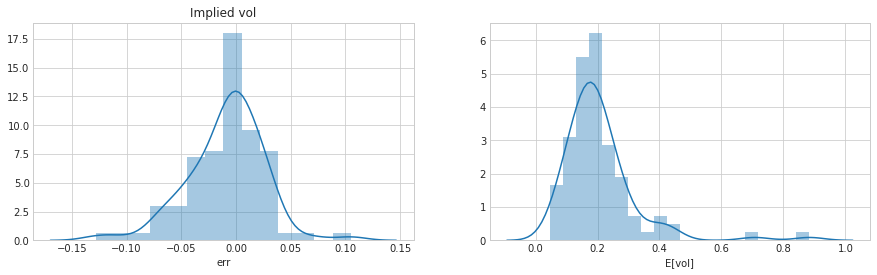

In [461]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
sns.distplot(results_["err"], ax=ax[0])
sns.distplot(results_["E[vol]"], ax=ax[1])
ax[0].set_title("Approximation error")
ax[0].set_title("Implied vol")
None

In [444]:
results_.loc[results_["err"].abs().sort_values().index].head(3)

,tau,spot,E[vol],sd[vol],vega,sd[pnl],~sd[pnl],err
41,2.0,30.760844,0.038231,0.003759,4.975359,0.019975,0.019982,0.000352
26,2.0,16.022921,0.251305,0.022566,2.588316,0.062435,0.062407,-0.000442
27,4.0,9.000569,0.009617,0.004186,2.067400,0.009242,0.009247,0.000588


In [446]:
results_.loc[results_["err"].abs().sort_values(ascending=False).index].head(3)

,tau,spot,E[vol],sd[vol],vega,sd[pnl],~sd[pnl],err
14,2.0,11.225635,0.323431,0.124826,1.811827,0.266828,0.241644,-0.094384
87,4.0,7.634705,0.066326,0.030554,1.753353,0.062712,0.057240,-0.087248
69,6.0,8.623473,0.025099,0.011346,2.429207,0.032127,0.029447,-0.083416
